In [1]:
!pip install matplotlib scipy mpmath

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
# Simple utilities
def imdisp(im):
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
    plt.axis('off')
    plt.show()

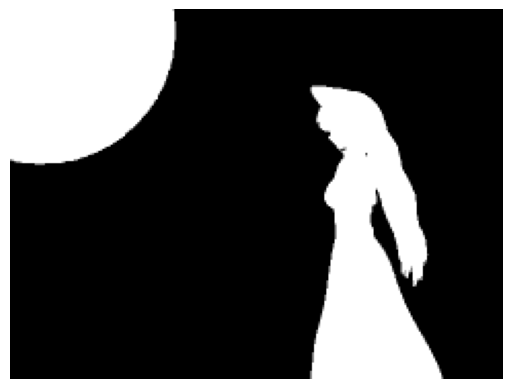

In [4]:
# Load image
image_gs = cv2.imread('frames/BadApple_3010.jpg', cv2.IMREAD_GRAYSCALE)
_, image = cv2.threshold(image_gs, 127 , 255, cv2.THRESH_BINARY)
image = cv2.resize(image, (0, 0), fx=0.5, fy=0.5)
imdisp(image)

Found 2 contours with lengths [471, 269].


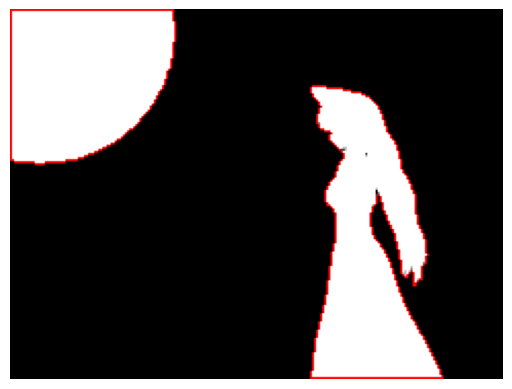

In [5]:
conts, hier = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
conts = [ i for i in conts if [0, 0] not in i or [179, 239] not in i ]
athresh = 10
conts = [ i for i in conts if cv2.contourArea(i) > athresh ]
print(f"Found {len(conts)} contours with lengths {[ len(i) for i in conts ]}.")
imdisp(cv2.drawContours(cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR), conts, -1, (0,0,255), 1))

In [6]:
deplsize = 40
depl = 179 - 20
def place_in_mosfet(xs):
    deplr = [ depl for _ in range(deplsize) ]
    return deplr + xs + deplr
total_width = 239 + (2 * deplsize)
print(total_width)

319


In [7]:
def contour_to_lines(cont):
    contmap = {}
    for [[x, y]] in cont:
        if x not in contmap:
            contmap[x] = []
        contmap[x].append(y)
    rlines = [{}, {}]
    entrance, exit = None, None
    for x, ys in contmap.items():
        # Entrance:
        if entrance is None:
            entrance = (x, max(ys))
        else:
            (prev_x, _) = entrance
            if x < prev_x:
                entrance = (x, max(ys))
        if entrance is None:
            entrances = (x, min(ys))
        else:
            (prev_x, _) = entrance
            if x < prev_x:
                entrance = (x, min(ys))
        # Exit:
        if exit is None:
            exit = (x, max(ys))
        else:
            (prev_x, _) = exit
            if x > prev_x:
                exit = (x, max(ys))
        if exit is None:
            exits = (x, min(ys))
        else:
            (prev_x, _) = exit
            if x > prev_x:
                exit = (x, min(ys))
        # Normal:
        rlines[0][x] = max(ys)
        rlines[1][x] = min(ys)
    lines = [[], []]
    lasts = [ i for (_, i) in [entrance, entrance] ]
    for x in range(239):
        if x >= exit[0]:
            lines[0].append(179 - exit[1])
            lines[1].append(179 - exit[1])
            continue
        n1 = rlines[0].get(x, lasts[0])
        n2 = rlines[1].get(x, lasts[1])
        lines[0].append(179 - n1)
        lines[1].append(179 - n2)
        lasts[0] = n1
        lasts[1] = n2
    return [ place_in_mosfet(i) for i in lines ]
lines = contour_to_lines(conts[0])
[ len(i) for i in lines ]

[319, 319]

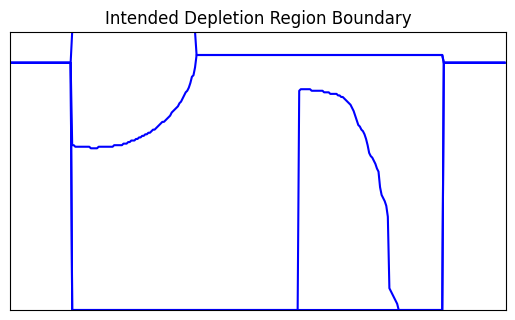

In [8]:
def plot_lines(conts):
    plt.ylim((0, 179))
    plt.xlim((0, total_width))
    plt.gca().set_aspect(1)
    plt.title("Intended Depletion Region Boundary")
    plt.gca().axes.yaxis.set_visible(False)
    plt.gca().axes.xaxis.set_visible(False)
    lines_list = [ contour_to_lines(cont) for cont in conts ]
    for lines in lines_list:
        plt.plot(lines[0], color="blue")
        plt.plot(lines[1], color="blue")
    plt.show()
plot_lines(conts)

I'm getting the values and calculation of $V_{FB}$ from [here](https://h-gens.github.io/electrical-characteristics-of-the-mos-capacitor.html).

In [29]:
# (not mine) Physical Constants:
e_0 = 8.854e-14 # Electric permittivity of free space (F cm^-1)
e = 1.602e-19 # Charge magnitude of an electron (C)
k = 8.617e-5 # Boltzmann's constant (eV / K)
# (not mine) Material Constants:
e_si = 11.7 # Relative electric permittivity of Silicon (dimensionless)
e_ox = 3.9 # Relative electric permittivity of SiO2 (dimensionless)
N_A = 1e17 # Acceptor doping concentration (cm^-3)
t_ox = 50e-6 # Oxide layer thickness (cm)
# (not mine) Material Constants used for calculating V_FB only:
chi_s = 4.17 # electron affinity, silicon (eV)
phi_m = 5.01 # work function, nickel (eV)
T = 300 # lattice temperature (K)
Eg = 1.17 - 4.73e-4 * T ** 2 / (T + 636.0) # bandgap, silicon (eV)
Nv = 3.5e15 * T ** 1.5 # effective valence band DOS, silicon (cm^-3
Nc = 6.2e15 * T ** 1.5 # effective conduction band DOS, silicon, (cm^-3)
Nd = 1e16 # donor doping concentration (cm^-3)
Na, tox, e0, q, es = N_A, t_ox, e_0, e, e_si

In [10]:
# NOT MY CODE!!!!, SEE: https://h-gens.github.io/electrical-characteristics-of-the-mos-capacitor.html
# -----------------------
# dependent calculations
# -----------------------
from scipy.integrate import quad
# create smoothing functions
# - smoothly transitions to near-zero as f approaches zero
# - eps is the minimum value |f| reaches
def Sp(f, eps=1e-3):
    return (f + np.sqrt(f ** 2 + 4 * eps ** 2)) / 2.0
def Sn(f, eps=1e-3):
    return (f - np.sqrt(f ** 2 + 4 * eps ** 2)) / 2.0
def solve_bisection(func, target, xmin, xmax):
    # Returns the independent value x satisfying func(x)=value.
    # uses the bisection search method: https://en.wikipedia.org/wiki/Bisection_method
    tol = 1e-9 # when |a - b| <= tol, quit searching
    max_iters = 1e2 # maximum number of iterations
    a = xmin
    b = xmax
    cnt = 1
    Fa = target - func(a)
    c = a
    # bisection search loop
    while np.abs(a - b) > tol and cnt < max_iters:
        cnt += 1
        # make 'c' be the midpoint between 'a' and 'b'
        c = (a + b) / 2.0
        # calculate at the new 'c'
        Fc = target - func(c)

        if Fc == 0:
            # 'c' was the sought-after solution, so quit
            break
        elif np.sign(Fa) == np.sign(Fc):
            a = c # the signs were the same, so modify 'a'
            Fa = Fc # also update computed value
        else:
            b = c # the signs were different, so modify 'b'
    if cnt == max_iters:
        print('WARNING: max iterations reached')
    return c
# intrinsic carrier concentration, silicon, # / cm^3
ni = np.sqrt(Nc * Nv) * np.exp(-Eg / (2 * k * T))
# Energy levels are relative to one-another in charge expressions.
# - Therefore, it is OK to set Ev to a reference value of 0 eV.
# Usually, energy levels are given in Joules and one converts to eV.
# - I have just written each in eV to save time.
Ev = 0 # valence band energy level
Ec = Eg # conduction band energy level
Ei = k * T * np.log(ni / Nc) + Ec # intrinsic energy level
phit = k * T # thermal voltage, eV
# get the Fermi level in the bulk where there is no band-bending
n = lambda Ef: Nc * np.exp((-Ec + Ef) / phit)
p = lambda Ef: Nv * np.exp((Ev - Ef) / phit)
func = lambda Ef: p(Ef) - n(Ef) + Nd - Na
Ef = solve_bisection(func, 0, Ev, Ec)
# compute semiconductor work function (energy from vacuum to Ef)
phi_s = chi_s + Ec - Ef
# flatband voltage and its constituent(s)
# - no defect-related charges considered
phi_ms = phi_m - phi_s # metal-semiconductor workfunction, eV
V_FB = phi_ms # flatband voltage, V
print(f"V_FB = {V_FB}")
# ^^^ NOT MY CODE, SEE: https://h-gens.github.io/electrical-characteristics-of-the-mos-capacitor.html (end of not my code)

V_FB = -0.14728591344484965


In [these slides](https://inst.eecs.berkeley.edu/~ee105/sp08/lectures/lecture15_2.pdf), we find the following equation:
$$X_d = \frac{\varepsilon_{Si}}{C_{ox}}\left[\sqrt{1 + \frac{2C_{ox}^2(V_{G} - V_{FB})}{q \varepsilon_{Si} N_A}} - 1\right]$$
We know that $C_{ox} = \varepsilon_{ox} \varepsilon_0 / t_{ox}$, allowing us to make it:
$$X_d = \frac{\varepsilon_{Si} t_{ox}}{\varepsilon_{ox} \varepsilon_0}\left[\sqrt{1 + \frac{2(\frac{\varepsilon_{ox} \varepsilon_0}{t_{ox}})^2(V_{G} - V_{FB})}{q \varepsilon_{Si} N_A}} - 1\right]$$

Finally, we can break this up into some constants to make it easier to work with:
$$X_d = k_1\left(\sqrt{1+k_2(V_G-V_{FB})}-1\right)$$
Where:
$$k_1 = \frac{\varepsilon_{Si} t_{ox}}{\varepsilon_{ox} \varepsilon_0}$$
$$k_2 = \frac{2(\frac{\varepsilon_{ox} \varepsilon_0}{t_{ox}})^2}{q \varepsilon_{Si} N_A}$$

In [41]:
C_ox = (e_ox * e_0) / t_ox
k_1 = e_si / C_ox
k_2 = (2 * (C_ox ** 2)) / (e * e_si * N_A)
print("Parameters for Depletion Region Depth:")
print("k_1 = " + repr(k_1))
print("k_2 = " + repr(k_2))
print("V_FB = " + repr(V_FB))

Parameters for Depletion Region Depth:
k_1 = 1694149536.93246
k_2 = 5.089204034956304e-16
V_FB = -0.14728591344484965


In [40]:
from mpmath import mpf
import mpmath
mpmath.mp.dps = 50
def xd_from_vg(V_G):
    insqrt = mpf(1) + (mpf(k_2) * mpf(V_G - V_FB))
    sqrtexpr = mpf.sqrt(insqrt)
    X_d = mpf(k_1) * (sqrtexpr - mpf(1))
    return float(X_d)

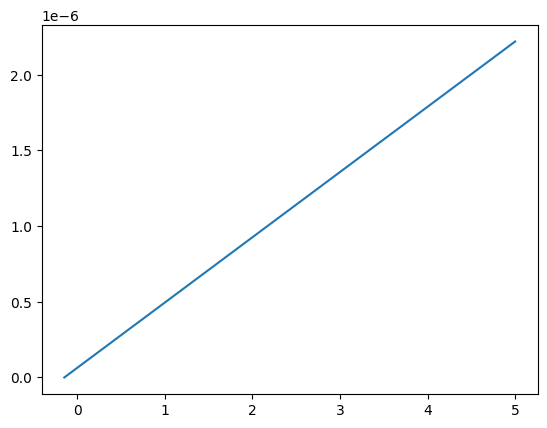

In [42]:
def show_xd_forward():
    X = np.linspace(V_FB, 5.0, 100)
    Y = np.vectorize(xd_from_vg)(X)
    plt.plot(X, Y)
    plt.show()
show_xd_forward()